In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from ghcnd_fetch import *

In [18]:
def prompt_station_selection():
    stations_df = get_ghcnd_stations()
    # Create a display string "ID - NAME" for each station.
    stations_df["display"] = stations_df["ID"] + " - " + stations_df["NAME"].str.strip()

    # Print a numbered list of available stations.
    print("Available Stations:")
    for idx, display in enumerate(stations_df["display"].tolist()):
        print(f"{idx}: {display}")

    # Prompt the user to select a station.
    try:
        index = int(input("\nEnter the number of the station to download: "))
        if index < 0 or index >= len(stations_df):
            print("Invalid index. Exiting.")
            return
    except ValueError:
        print("Invalid input. Please enter a valid number.")
        return

    selected_station = stations_df.iloc[index]
    station_id = selected_station["ID"]
    print(f"\nSelected Station: {station_id} - {selected_station['NAME'].strip()}")
    return station_id

In [19]:
station_id = prompt_station_selection()
df = get_ghcnd_data_by_station(station_id)
df

Available Stations:
0: ACW00011604 - ST JOHNS COOLIDGE FLD
1: ACW00011647 - ST JOHNS
2: AE000041196 - SHARJAH INTER. AIRP
3: AEM00041194 - DUBAI INTL
4: AEM00041217 - ABU DHABI INTL
5: AEM00041218 - AL AIN INTL
6: AF000040930 - NORTH-SALANG
7: AFM00040938 - HERAT
8: AFM00040948 - KABUL INTL
9: AFM00040990 - KANDAHAR AIRPORT
10: AG000060390 - ALGER-DAR EL BEIDA
11: AG000060590 - EL-GOLEA
12: AG000060611 - IN-AMENAS
13: AG000060680 - TAMANRASSET
14: AGE00135039 - ORAN-HOPITAL MILITAIRE
15: AGE00147704 - ANNABA-CAP DE GARDE
16: AGE00147705 - ALGIERS-VILLE/UNIVERSITE
17: AGE00147706 - ALGIERS-BOUZAREAH
18: AGE00147707 - ALGIERS-CAP CAXINE
19: AGE00147708 - TIZI OUZOU
20: AGE00147709 - FORT NATIONAL
21: AGE00147710 - BEJAIA-BOUGIE (PORT)
22: AGE00147711 - CONSTANTINE
23: AGE00147712 - ORLEANSVILLE (CHLEF)
24: AGE00147713 - SETIF
25: AGE00147714 - ORAN-CAP FALCON
26: AGE00147715 - TEBESSA
27: AGE00147716 - NEMOURS (GHAZAOUET)
28: AGE00147717 - SIDI-BEL-ABBES
29: AGE00147718 - BISKRA
30: AGE0

station_id  year  month  day element  value mflag qflag sflag
0      ACW00011647  1957      9    1    PRCP    0.0  None  None     X
1      ACW00011647  1957      9    2    PRCP    0.0  None  None     X
2      ACW00011647  1957      9    3    PRCP    0.0  None  None     X
3      ACW00011647  1957      9    4    PRCP    3.0  None  None     X
4      ACW00011647  1957      9    5    PRCP   15.0  None  None     X
...            ...   ...    ...  ...     ...    ...   ...   ...   ...
13449  ACW00011647  1970      2   27    SNWD    NaN  None  None  None
13450  ACW00011647  1970      2   28    SNWD    NaN  None  None  None
13451  ACW00011647  1970      2   29    SNWD    NaN  None  None  None
13452  ACW00011647  1970      2   30    SNWD    NaN  None  None  None
13453  ACW00011647  1970      2   31    SNWD    NaN  None  None  None

[13454 rows x 9 columns]

In [22]:
def clean_and_resample_data(data):
    # Create a DATE column from year, month, and day columns.
    # Use errors='coerce' to handle any invalid date values.
    data["DATE"] = pd.to_datetime(data[["year", "month", "day"]], errors="coerce")

    # Drop rows where date conversion failed (NaT)
    data = data.dropna(subset=["DATE"])

    # Drop rows with missing temperature values in the 'value' column
    data = data.dropna(subset=["value"])

    # TODO: do proper unit conversion based on the 'unit' column
    data['value'] = data['value'].astype(float)

    # TODO: figure out if dropping NA then resampling is the right approach compared to resampling then dropping NA
    # Set DATE as the index and keep only the temperature values
    data = data.set_index("DATE")[["value"]]

    data = data.resample("M").mean()  # Resample to monthly frequency
    data = data.dropna()  # Drop any rows with NaN values after resampling
    return data


/var/folders/pw/1zr89f35601_sz5xftx99jv00000gn/T/ipykernel_82373/1206507563.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample("M").mean()  # Resample to monthly frequency
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  137
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -343.420
Date:                            Mon, 14 Apr 2025   AIC                            696.840
Time:                                    17:35:40   BIC                            710.342
Sample:                                         0   HQIC                           702.316
                                            - 137                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1296      0.117      1.107      0.268      -0.100       0.359
ma.L1         -0.8994      0.063   

/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


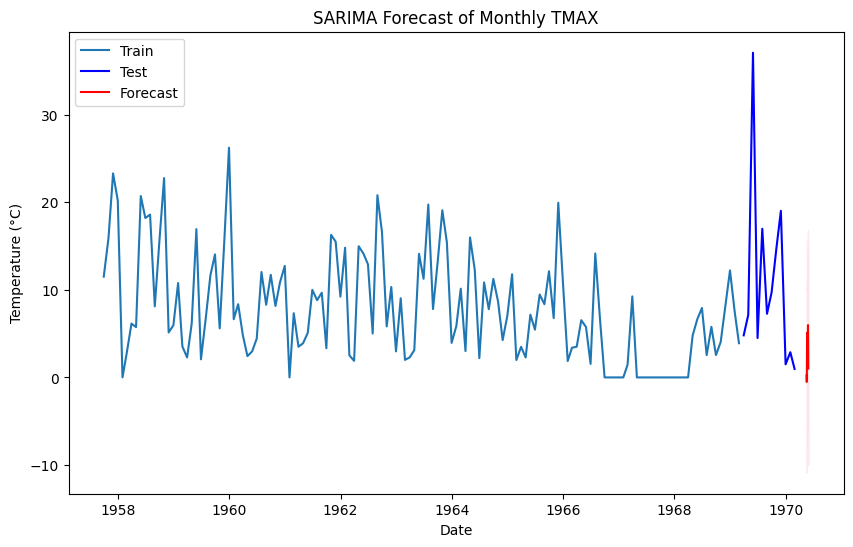

Mean Squared Error: 159.72001087998504


In [23]:
df = clean_and_resample_data(df)

# Check that there is enough data to split into training and testing sets
if len(df) < 24:
    raise ValueError("Not enough data to split into training and testing sets.")

# Reserve the last 12 months for testing
train = df.iloc[:-12]
test = df.iloc[-12:]

# Define SARIMA parameters.
# Adjust these parameters if needed based on your dataset's characteristics.
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit the SARIMA model on the training data.
model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Print a summary of the fitted model.
print(model_fit.summary())

# Forecast for the test period.
forecast_obj = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_obj.predicted_mean
forecast_conf_int = forecast_obj.conf_int()

# Plot the training data, test data, and forecasted values.
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="blue")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", color="red")
plt.fill_between(forecast_mean.index,
                    forecast_conf_int.iloc[:, 0],
                    forecast_conf_int.iloc[:, 1],
                    color="pink", alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("SARIMA Forecast of Monthly TMAX")
plt.legend()
plt.show()

# Calculate and print the Mean Squared Error (MSE) for the forecast.
mse = mean_squared_error(test, forecast_mean)
print("Mean Squared Error:", mse)

/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.p

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=910.124, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=894.159, Time=0.11 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=865.394, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=908.134, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=863.394, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=865.394, Time=0.09 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.p

 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=867.302, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.11 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=894.423, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=862.717, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=864.711, Time=0.06 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.p

 ARIMA(0,1,1)(0,0,1)[12]             : AIC=864.712, Time=0.17 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=858.060, Time=0.04 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=860.000, Time=0.17 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12]             : AIC=860.010, Time=0.14 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=861.900, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=892.443, Time=0.02 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12]             : AIC=859.784, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=859.296, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=857.477, Time=0.02 sec
 ARIMA(0,1,2)(1,0,0)[12]             : AIC=859.475, Time=0.06 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.p

 ARIMA(0,1,2)(0,0,1)[12]             : AIC=859.475, Time=0.08 sec


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=861.433, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[12]             : AIC=859.394, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[12]             : AIC=861.018, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[12]          
Total fit time: 4.662 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  137
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -425.738
Date:                Mon, 14 Apr 2025   AIC                            857.477
Time:                        17:35:52   BIC                            866.215
Sample:                             0   HQIC                           861.028
                                - 137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/si

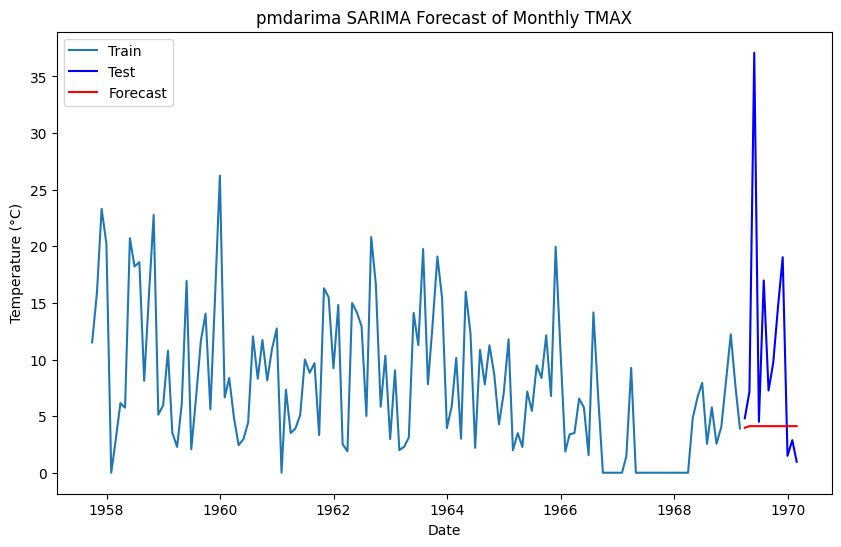

Mean Squared Error: 138.0670669710739


In [ ]:
# Clean the training and test datasets by dropping missing values
train_clean = train.dropna()
test_clean = test.dropna()

# Use auto_arima to fit a SARIMA model to the training data.
# m=12 indicates monthly seasonality.
model = auto_arima(
    train_clean,
    seasonal=True,
    m=12,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
)

# Print the model summary
print(model.summary())

# Forecast for the test period (using the length of the cleaned test set)
n_periods = len(test_clean)
forecast = model.predict(n_periods=n_periods)

# Plot the training data, test data, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train_clean.index, train_clean, label="Train")
plt.plot(test_clean.index, test_clean, label="Test", color="blue")
plt.plot(test_clean.index, forecast, label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("pmdarima SARIMA Forecast of Monthly TMAX")
plt.legend()
plt.show()

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(test_clean, forecast)
print("Mean Squared Error:", mse)



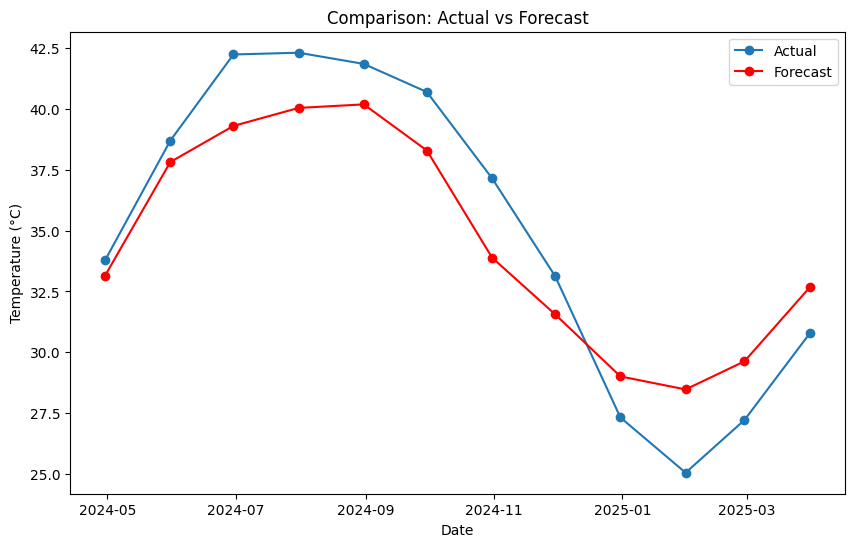

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(test_clean.index, test_clean, label="Actual", marker="o")
plt.plot(test_clean.index, forecast, label="Forecast", marker="o", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Comparison: Actual vs Forecast")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Example: Using 3 splits for time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
errors = []

for train_index, test_index in tscv.split(df):
    train_cv, test_cv = monthly_data.iloc[train_index], monthly_data.iloc[test_index]
    # Make sure to clean or impute missing values here if necessary
    train_cv = train_cv.dropna()
    test_cv = test_cv.dropna()

    model = auto_arima(
        train_cv,
        seasonal=True,
        m=12,
        trace=False,
        error_action="ignore",
        suppress_warnings=True,
    )

    n_periods = len(test_cv)
    forecast = model.predict(n_periods=n_periods)

    mse_cv = mean_squared_error(test_cv, forecast)
    errors.append(mse_cv)

print("Cross-validated MSEs:", errors)
print("Average MSE:", np.mean(errors))

/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.p

Cross-validated MSEs: [8.306100110390965, 3.136687789713715, 76.2283262896909]
Average MSE: 29.223704729931857


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/var/folders/pw/1zr89f35601_sz5xftx99jv00000gn/T/ipykernel_82373/3626445351.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:]
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS P

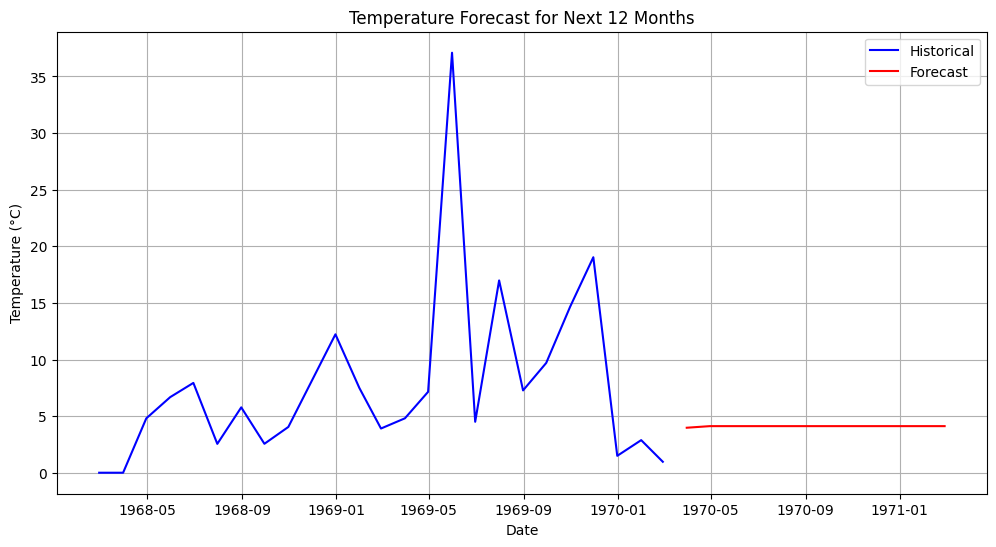


Forecasted temperatures for the next 12 months:
      Date  Forecast Temperature (°C)
1970-03-31                   3.973436
1970-04-30                   4.114898
1970-05-31                   4.114898
1970-06-30                   4.114898
1970-07-31                   4.114898
1970-08-31                   4.114898
1970-09-30                   4.114898
1970-10-31                   4.114898
1970-11-30                   4.114898
1970-12-31                   4.114898
1971-01-31                   4.114898
1971-02-28                   4.114898


In [25]:
# Get the last date in our data
last_date = df.index[-1]

# Generate dates for the next 12 months
future_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:]

# Use the model to forecast the next 12 months
forecast = model.predict(n_periods=12)

# Create a plot
plt.figure(figsize=(12, 6))

# Plot historical data (last 24 months for better visibility)
plt.plot(df.index[-24:], df.value[-24:], label='Historical', color='blue')

# Plot forecast
plt.plot(future_dates, forecast, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Forecast for Next 12 Months')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted values with dates
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast Temperature (°C)': forecast})
print("\nForecasted temperatures for the next 12 months:")
print(forecast_df.to_string(index=False))


Temperature Change Statistics (1983-2025):
Average yearly increase: -0.728°C per year
Total temperature change over period: -10.19°C
Average temperature first 5 years: 10.84°C
Average temperature last 5 years: 4.37°C


/var/folders/pw/1zr89f35601_sz5xftx99jv00000gn/T/ipykernel_82373/1143639348.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = df.resample("Y").mean()


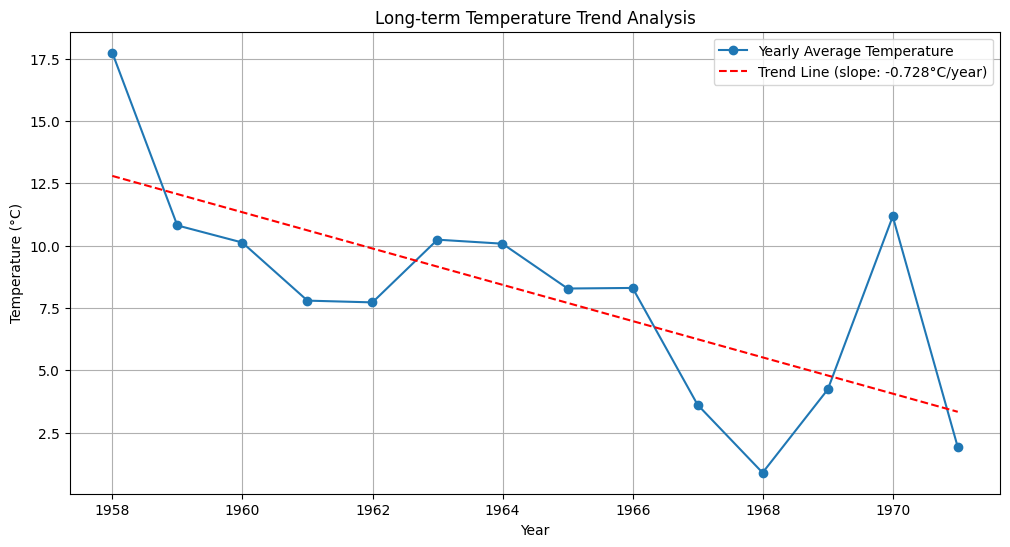

In [26]:
# Calculate yearly averages to see long-term temperature trends
yearly_data = df.resample("Y").mean()

# Create a plot showing historical yearly averages and trend
plt.figure(figsize=(12, 6))

# Plot yearly averages
plt.plot(
    yearly_data.index,
    yearly_data["value"],
    marker="o",
    label="Yearly Average Temperature",
)

# Add trend line using numpy's polyfit
z = np.polyfit(range(len(yearly_data)), yearly_data["value"], 1)
p = np.poly1d(z)
plt.plot(
    yearly_data.index,
    p(range(len(yearly_data))),
    "r--",
    label=f"Trend Line (slope: {z[0]:.3f}°C/year)",
)

plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Long-term Temperature Trend Analysis")
plt.legend()
plt.grid(True)

# Calculate and print statistics
total_change = z[0] * len(yearly_data)
print(f"\nTemperature Change Statistics (1983-2025):")
print(f"Average yearly increase: {z[0]:.3f}°C per year")
print(f"Total temperature change over period: {total_change:.2f}°C")
print(f"Average temperature first 5 years: {yearly_data['value'].head().mean():.2f}°C")
print(f"Average temperature last 5 years: {yearly_data['value'].tail().mean():.2f}°C")